**Pressure reducing valves (PRVs)** are unidirectional links that limit the pressure head at the node downstream to the valve to be equal to or below a prescribed pressure setting value. At each time step in the simulation duration, PRV status is determined based on the relationship between upstream and downstream node heads and the pressure setting value (Hu, Hd, and Hset respectively).

If Hu > Hset > Hd, then the PRV is **active** and Hd is set to = Hset.
If Hset > Hu > Hd, then the PRV is **open** and the heads are unchanged.
If Hd > Hu, then the PRV is **closed**, flow through the PRV is 0, and the upstream and downstream nodes are disconnected.

This notebook demonstrates how the pipedream PRV control structure behaves for a toy network with 3 junctions, network Net2 (with 35 junctions), and network ky6 (with 543 junctions). We compare pipedream and WNTR (using EPANET engine) hydraulic simulation results to observe the accuracy of the pipedream model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample
import pipedream_utility as pdu
from pipedream_utility import *
import pipedream_simulation as pd_sim
from pipedream_simulation import *
import viswaternet as vis
import math

#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
dt = 3600
t_run = 24

# 1. Toy network: open PRV

In [3]:
# import INP file
inp = 'Networks/PRV_open.inp'

In [4]:
# run hydraulic simulation using pipedream
H_df, Q_df, Q_pump, Q_prv, model, Q_in_all_df, pumps, superjunctions, orifices, superlinks, prvs = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# run hydraulic simulation using WNTR
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# store WNTR results for time series plotting
wntr_results_head=results.node['head'].iloc[:-1,:]
wntr_results_flow=results.link['flowrate'].iloc[:-1,:]

# store mean absolute difference (MAD) between pipedream and WNTR head and flow results
abs_diff_node = abs(results.node['head']-H_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()
abs_diff_link = 3600*abs(results.link['flowrate']-Q_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()

print(' Absolute difference in node heads [m]:', abs_diff_node.mean(), ' and link flow rates [m3/hr]:', abs_diff_link.mean())

 Absolute difference in node heads [m]: 0.0037121378138264363  and link flow rates [m3/hr]: 1.242886135478638


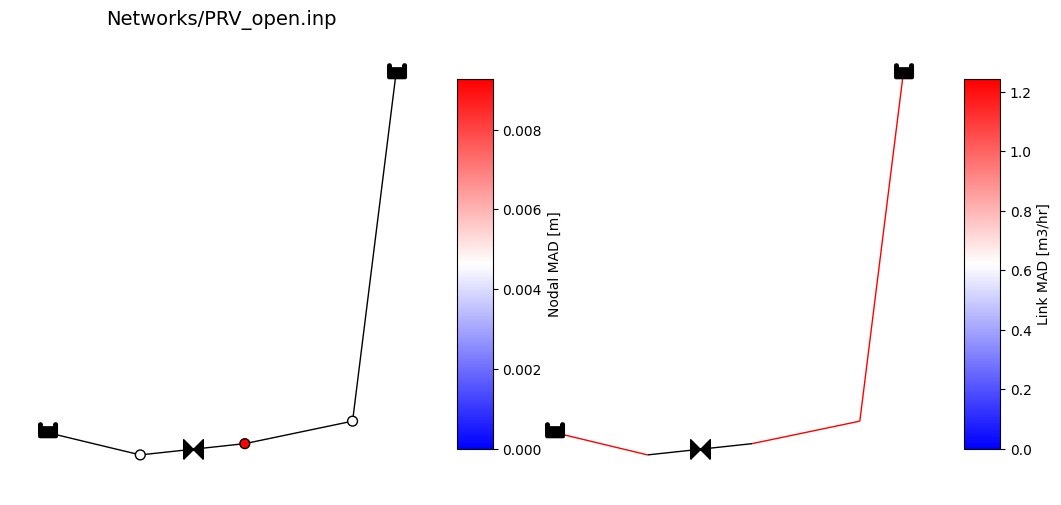

In [5]:
# plot network layout show MAD at nodes and pipes

fig, ax = plt.subplots(1, 2, figsize = (12,6))
node_size = 200


junction_names = list(abs_diff_node.index)
link_names = list(abs_diff_link.index)
junction_values = list(abs_diff_node)
link_values = list(abs_diff_link)   

vis_model = vis.VisWNModel(inp)

ax[0].set_title(inp, fontsize = 14)
ax[0].set_frame_on(False) 

style = vis.NetworkStyle(cmap = 'bwr', node_border_width=1, node_border_color = 'k', draw_color_bar = True,  
                                   node_size = node_size, tank_color='k', draw_base_legend=False)

vis_model.plot_unique_data(ax=ax[0], parameter = "custom_data", parameter_type = 'node', 
                                   custom_data_values = [junction_names, junction_values], data_type = 'continuous', 
                                    vmin = 0, style = style, color_bar_title ='Nodal MAD [m]')

ax[1].set_frame_on(False) 
vis_model.plot_unique_data(ax=ax[1], parameter = "custom_data", parameter_type = 'link', 
                                   custom_data_values = [link_names, link_values], data_type = 'continuous', 
                                   vmin = 0, style = style, color_bar_title ='Link MAD [m3/hr]')


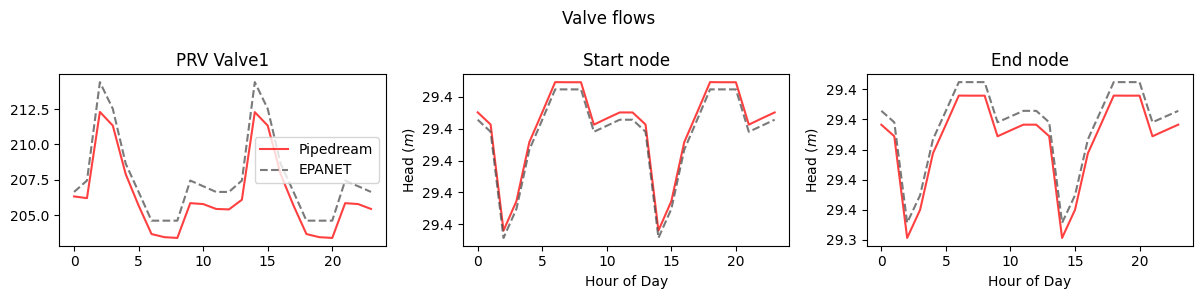

In [6]:
# plot pipedream and wntr PRV flows and upstream + downstream node heads
n_superlinks = wn.num_valves
n_cols = 3
n_rows =wn.num_valves  

if wn.num_valves > 0:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 0.75 * 12 * n_rows / n_cols))
    for i in range(wn.num_valves):
        valve = wn.get_link(wn.valve_name_list[i])
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*Q_prv[:,i:i+1], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*wntr_results_flow[wn.valve_name_list[i]], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i].set_title(f'{wn.get_link(wn.valve_name_list[i]).valve_type} {wn.valve_name_list[i]}')

        ax.flat[3*i+1].plot(H_df.index/3600,H_df[valve.start_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+1].plot(wntr_results_head.index/3600,wntr_results_head[valve.start_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+1].set_title('Start node')
        ax.flat[3*i+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+1].set_ylabel('Head ($m$)')
        ax.flat[3*i+1].set_xlabel('Hour of Day')

        ax.flat[3*i+2].plot(H_df.index/3600,H_df[valve.end_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+2].plot(wntr_results_head.index/3600,wntr_results_head[valve.end_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+2].set_title('End node')
        ax.flat[3*i+2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+2].set_ylabel('Head ($m$)')
        ax.flat[3*i+2].set_xlabel('Hour of Day')


    ax.flat[0].legend()
    plt.suptitle('Valve flows')
    plt.tight_layout()

# 2. Toy network: active PRV

In [7]:
# import INP file
inp = 'Networks/PRV_active.inp'

In [8]:
# run hydraulic simulation using pipedream
H_df, Q_df, Q_pump, Q_prv, model, Q_in_all_df, pumps, superjunctions, orifices, superlinks, prvs = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# run hydraulic simulation using WNTR
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# store WNTR results for time series plotting
wntr_results_head=results.node['head'].iloc[:-1,:]
wntr_results_flow=results.link['flowrate'].iloc[:-1,:]

# store mean absolute difference (MAD) between pipedream and WNTR head and flow results
abs_diff_node = abs(results.node['head']-H_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()
abs_diff_link = 3600*abs(results.link['flowrate']-Q_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()

print(' Absolute difference in node heads [m]:', abs_diff_node.mean(), ' and link flow rates [m3/hr]:', abs_diff_link.mean())

 Absolute difference in node heads [m]: 0.002081947717062397  and link flow rates [m3/hr]: 0.9557085368231356


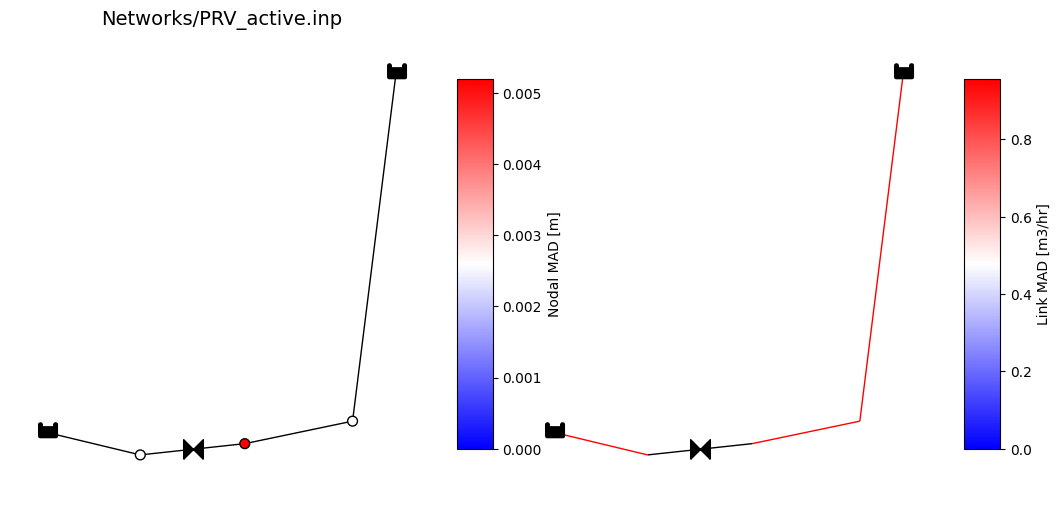

In [9]:
# plot network layout show MAD at nodes and pipes

fig, ax = plt.subplots(1, 2, figsize = (12,6))
node_size = 200


junction_names = list(abs_diff_node.index)
link_names = list(abs_diff_link.index)
junction_values = list(abs_diff_node)
link_values = list(abs_diff_link)   

vis_model = vis.VisWNModel(inp)

ax[0].set_title(inp, fontsize = 14)
ax[0].set_frame_on(False) 

style = vis.NetworkStyle(cmap = 'bwr', node_border_width=1, node_border_color = 'k', draw_color_bar = True,  
                                   node_size = node_size, tank_color='k', draw_base_legend=False)

vis_model.plot_unique_data(ax=ax[0], parameter = "custom_data", parameter_type = 'node', 
                                   custom_data_values = [junction_names, junction_values], data_type = 'continuous', 
                                    vmin = 0, style = style, color_bar_title ='Nodal MAD [m]')

ax[1].set_frame_on(False) 
vis_model.plot_unique_data(ax=ax[1], parameter = "custom_data", parameter_type = 'link', 
                                   custom_data_values = [link_names, link_values], data_type = 'continuous', 
                                   vmin = 0, style = style, color_bar_title ='Link MAD [m3/hr]')


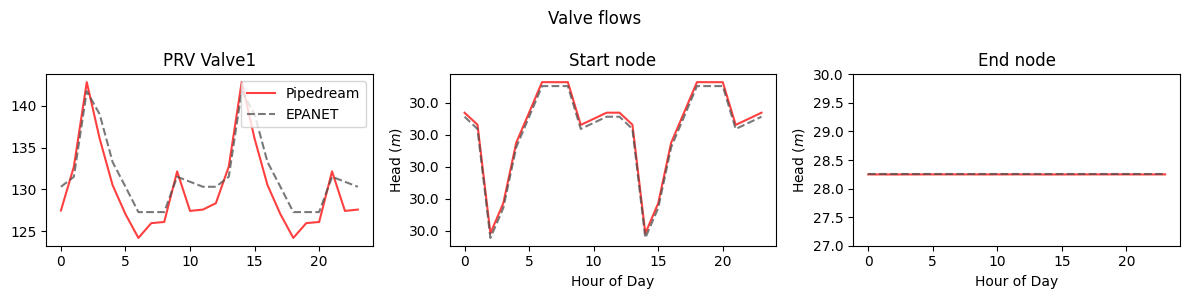

In [10]:
# plot pipedream and wntr PRV flows and upstream + downstream node heads
n_superlinks = wn.num_valves
n_cols = 3
n_rows =wn.num_valves  

if wn.num_valves > 0:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 0.75 * 12 * n_rows / n_cols))
    for i in range(wn.num_valves):
        valve = wn.get_link(wn.valve_name_list[i])
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*Q_prv[:,i:i+1], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*wntr_results_flow[wn.valve_name_list[i]], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i].set_title(f'{wn.get_link(wn.valve_name_list[i]).valve_type} {wn.valve_name_list[i]}')

        ax.flat[3*i+1].plot(H_df.index/3600,H_df[valve.start_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+1].plot(wntr_results_head.index/3600,wntr_results_head[valve.start_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+1].set_title('Start node')
        ax.flat[3*i+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+1].set_ylabel('Head ($m$)')
        ax.flat[3*i+1].set_xlabel('Hour of Day')

        ax.flat[3*i+2].plot(H_df.index/3600,H_df[valve.end_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+2].plot(wntr_results_head.index/3600,wntr_results_head[valve.end_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+2].set_title('End node')
        ax.flat[3*i+2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+2].set_ylabel('Head ($m$)')
        ax.flat[3*i+2].set_xlabel('Hour of Day')
        ax.flat[3*i+2].set_ylim(math.floor(wntr_results_head[valve.end_node_name][0])-1, math.ceil(wntr_results_head[valve.end_node_name][0])+1)


    ax.flat[0].legend()
    plt.suptitle('Valve flows')
    plt.tight_layout()

# 3. Toy network: closed PRV

In [11]:
# import INP file
inp = 'Networks/PRV_closed.inp'

In [12]:
# run hydraulic simulation using pipedream
H_df, Q_df, Q_pump, Q_prv, model, Q_in_all_df, pumps, superjunctions, orifices, superlinks, prvs = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# run hydraulic simulation using WNTR
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# store WNTR results for time series plotting
wntr_results_head=results.node['head'].iloc[:-1,:]
wntr_results_flow=results.link['flowrate'].iloc[:-1,:]

# store mean absolute difference (MAD) between pipedream and WNTR head and flow results
abs_diff_node = abs(results.node['head']-H_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()
abs_diff_link = 3600*abs(results.link['flowrate']-Q_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()

print(' Absolute difference in node heads [m]:', abs_diff_node.mean(), ' and link flow rates [m3/hr]:', abs_diff_link.mean())

 Absolute difference in node heads [m]: 9.366268723235057e-05  and link flow rates [m3/hr]: 2.0613780571387963e-05


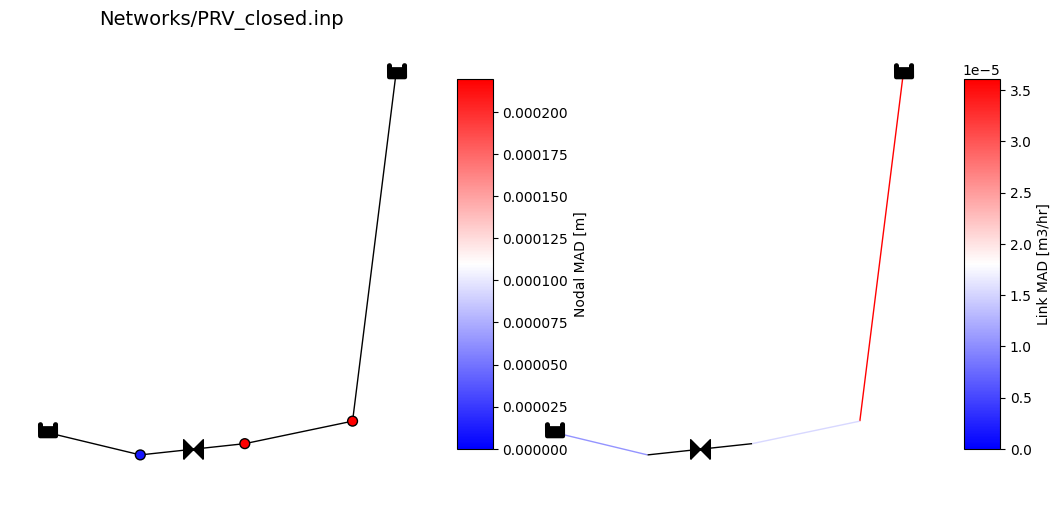

In [13]:
# plot network layout show MAD at nodes and pipes

fig, ax = plt.subplots(1, 2, figsize = (12,6))
node_size = 200


junction_names = list(abs_diff_node.index)
link_names = list(abs_diff_link.index)
junction_values = list(abs_diff_node)
link_values = list(abs_diff_link)   

vis_model = vis.VisWNModel(inp)

ax[0].set_title(inp, fontsize = 14)
ax[0].set_frame_on(False) 

style = vis.NetworkStyle(cmap = 'bwr', node_border_width=1, node_border_color = 'k', draw_color_bar = True,  
                                   node_size = node_size, tank_color='k', draw_base_legend=False)

vis_model.plot_unique_data(ax=ax[0], parameter = "custom_data", parameter_type = 'node', 
                                   custom_data_values = [junction_names, junction_values], data_type = 'continuous', 
                                    vmin = 0, style = style, color_bar_title ='Nodal MAD [m]')

ax[1].set_frame_on(False) 
vis_model.plot_unique_data(ax=ax[1], parameter = "custom_data", parameter_type = 'link', 
                                   custom_data_values = [link_names, link_values], data_type = 'continuous', 
                                   vmin = 0, style = style, color_bar_title ='Link MAD [m3/hr]')


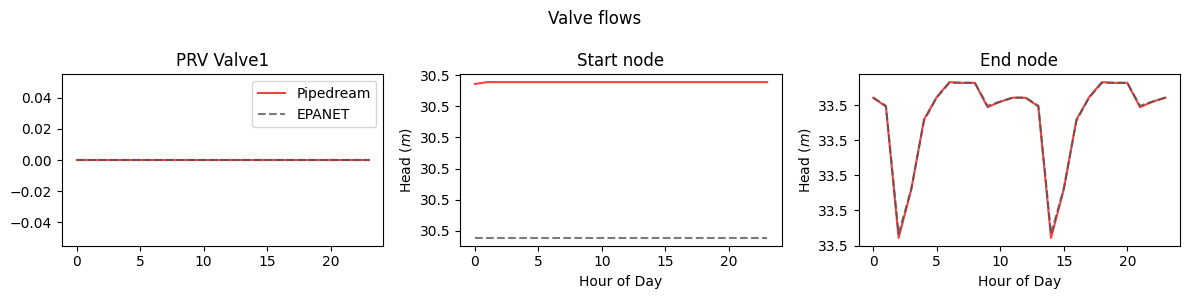

In [14]:
# plot pipedream and wntr PRV flows and upstream + downstream node heads
n_superlinks = wn.num_valves
n_cols = 3
n_rows =wn.num_valves  

if wn.num_valves > 0:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 0.75 * 12 * n_rows / n_cols))
    for i in range(wn.num_valves):
        valve = wn.get_link(wn.valve_name_list[i])
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*Q_prv[:,i:i+1], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*wntr_results_flow[wn.valve_name_list[i]], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i].set_title(f'{wn.get_link(wn.valve_name_list[i]).valve_type} {wn.valve_name_list[i]}')

        ax.flat[3*i+1].plot(H_df.index/3600,H_df[valve.start_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+1].plot(wntr_results_head.index/3600,wntr_results_head[valve.start_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+1].set_title('Start node')
        ax.flat[3*i+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+1].set_ylabel('Head ($m$)')
        ax.flat[3*i+1].set_xlabel('Hour of Day')

        ax.flat[3*i+2].plot(H_df.index/3600,H_df[valve.end_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+2].plot(wntr_results_head.index/3600,wntr_results_head[valve.end_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+2].set_title('End node')
        ax.flat[3*i+2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+2].set_ylabel('Head ($m$)')
        ax.flat[3*i+2].set_xlabel('Hour of Day')

    ax.flat[0].legend()
    plt.suptitle('Valve flows')
    plt.tight_layout()

# 4. Net2: open PRV

In [15]:
# import INP file
inp = 'Networks/Net2 prv open.inp'

In [16]:
# run hydraulic simulation using pipedream
H_df, Q_df, Q_pump, Q_prv, model, Q_in_all_df, pumps, superjunctions, orifices, superlinks, prvs = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# run hydraulic simulation using WNTR
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# store WNTR results for time series plotting
wntr_results_head=results.node['head'].iloc[:-1,:]
wntr_results_flow=results.link['flowrate'].iloc[:-1,:]

# store mean absolute difference (MAD) between pipedream and WNTR head and flow results
abs_diff_node = abs(results.node['head']-H_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()
abs_diff_link = 3600*abs(results.link['flowrate']-Q_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()

print(' Absolute difference in node heads [m]:', abs_diff_node.mean(), ' and link flow rates [m3/hr]:', abs_diff_link.mean())

 Absolute difference in node heads [m]: 0.12341813585611826  and link flow rates [m3/hr]: 1.1456692121917555


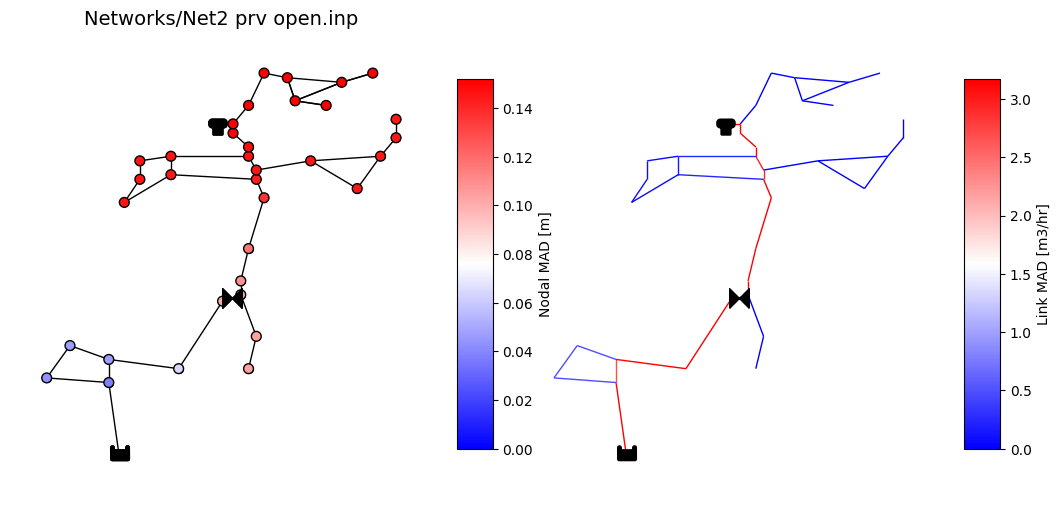

In [17]:
# plot network layout show MAD at nodes and pipes

fig, ax = plt.subplots(1, 2, figsize = (12,6))
node_size = 200


junction_names = list(abs_diff_node.index)
link_names = list(abs_diff_link.index)
junction_values = list(abs_diff_node)
link_values = list(abs_diff_link)   

vis_model = vis.VisWNModel(inp)

ax[0].set_title(inp, fontsize = 14)
ax[0].set_frame_on(False) 

style = vis.NetworkStyle(cmap = 'bwr', node_border_width=1, node_border_color = 'k', draw_color_bar = True,  
                                   node_size = node_size, tank_color='k', draw_base_legend=False)

vis_model.plot_basic_elements(ax=ax[0], style = vis.NetworkStyle(node_size=0, draw_base_legend = False))
vis_model.plot_unique_data(ax=ax[0], parameter = "custom_data", parameter_type = 'node', 
                                   custom_data_values = [junction_names, junction_values], data_type = 'continuous', 
                                    vmin = 0, style = style, color_bar_title ='Nodal MAD [m]')

ax[1].set_frame_on(False) 
vis_model.plot_unique_data(ax=ax[1], parameter = "custom_data", parameter_type = 'link', 
                                   custom_data_values = [link_names, link_values], data_type = 'continuous', 
                                   vmin = 0, style = style, color_bar_title ='Link MAD [m3/hr]')


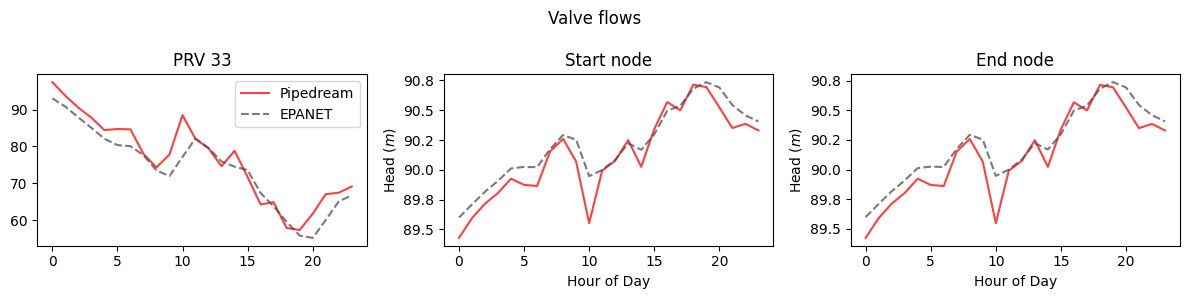

In [18]:
# plot pipedream and wntr PRV flows and upstream + downstream node heads
n_superlinks = wn.num_valves
n_cols = 3
n_rows =wn.num_valves  

if wn.num_valves > 0:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 0.75 * 12 * n_rows / n_cols))
    for i in range(wn.num_valves):
        valve = wn.get_link(wn.valve_name_list[i])
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*Q_prv[:,i:i+1], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*wntr_results_flow[wn.valve_name_list[i]], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i].set_title(f'{wn.get_link(wn.valve_name_list[i]).valve_type} {wn.valve_name_list[i]}')

        ax.flat[3*i+1].plot(H_df.index/3600,H_df[valve.start_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+1].plot(wntr_results_head.index/3600,wntr_results_head[valve.start_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+1].set_title('Start node')
        ax.flat[3*i+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+1].set_ylabel('Head ($m$)')
        ax.flat[3*i+1].set_xlabel('Hour of Day')

        ax.flat[3*i+2].plot(H_df.index/3600,H_df[valve.end_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+2].plot(wntr_results_head.index/3600,wntr_results_head[valve.end_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+2].set_title('End node')
        ax.flat[3*i+2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+2].set_ylabel('Head ($m$)')
        ax.flat[3*i+2].set_xlabel('Hour of Day')

    ax.flat[0].legend()
    plt.suptitle('Valve flows')
    plt.tight_layout()

# 5. ky6: active PRV

In [19]:
# import INP file
inp = 'Networks/headpump ky6 new.inp'

In [20]:
# run hydraulic simulation using pipedream
H_df, Q_df, Q_pump, Q_prv, model, Q_in_all_df, pumps, superjunctions, orifices, superlinks, prvs = run_pipedream_simulation(inp, t_run = t_run, dt = dt, banded = False)

# run hydraulic simulation using WNTR
wn = wntr.network.WaterNetworkModel(inp)
wn.options.time.report_timestep=dt    
wn.options.time.duration=t_run*3600
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# store WNTR results for time series plotting
wntr_results_head=results.node['head'].iloc[:-1,:]
wntr_results_flow=results.link['flowrate'].iloc[:-1,:]

# store mean absolute difference (MAD) between pipedream and WNTR head and flow results
abs_diff_node = abs(results.node['head']-H_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()
abs_diff_link = 3600*abs(results.link['flowrate']-Q_df).dropna(axis=1,how='all').dropna(axis=0,how='all').mean()

print(' Absolute difference in node heads [m]:', abs_diff_node.mean(), ' and link flow rates [m3/hr]:', abs_diff_link.mean())

C:\Users\mst2245\Box Sync\Research\8. Pipedream\PRV testing\pipedream_solver\nsuperlink.py:1293: LinAlgWarning: Ill-conditioned matrix (rcond=8.28742e-17): result may not be accurate.
  H_j_next = scipy.linalg.solve(l, r)


 Absolute difference in node heads [m]: 0.24708259277476405  and link flow rates [m3/hr]: 0.4644892295620231


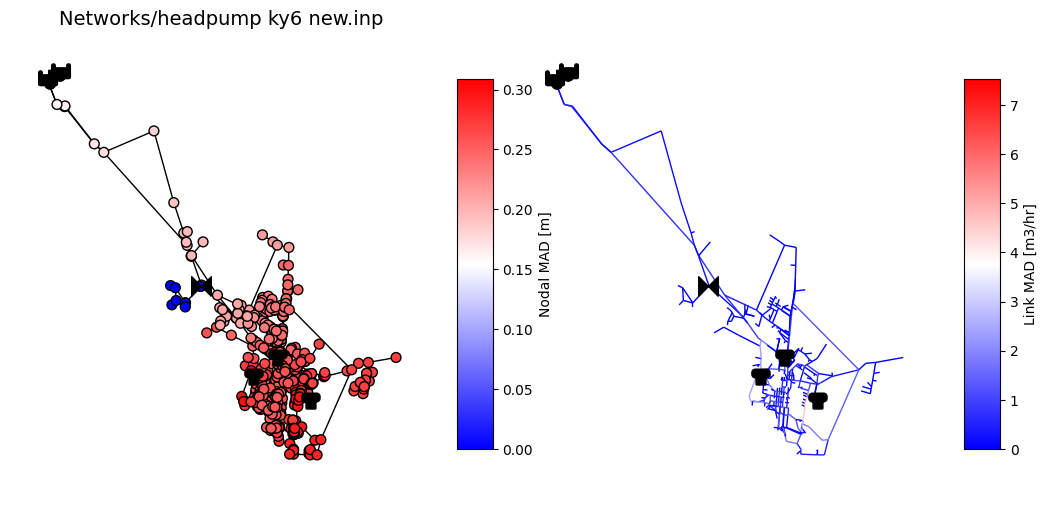

In [21]:
# plot network layout show MAD at nodes and pipes

fig, ax = plt.subplots(1, 2, figsize = (12,6))
node_size = 200


junction_names = list(abs_diff_node.index)
link_names = list(abs_diff_link.index)
junction_values = list(abs_diff_node)
link_values = list(abs_diff_link)   

vis_model = vis.VisWNModel(inp)

ax[0].set_title(inp, fontsize = 14)
ax[0].set_frame_on(False) 

style = vis.NetworkStyle(cmap = 'bwr', node_border_width=1, node_border_color = 'k', draw_color_bar = True,  
                                   node_size = node_size, tank_color='k', draw_base_legend=False)

vis_model.plot_unique_data(ax=ax[0], parameter = "custom_data", parameter_type = 'node', 
                                   custom_data_values = [junction_names, junction_values], data_type = 'continuous', 
                                    vmin = 0, style = style, color_bar_title ='Nodal MAD [m]')

ax[1].set_frame_on(False) 
vis_model.plot_unique_data(ax=ax[1], parameter = "custom_data", parameter_type = 'link', 
                                   custom_data_values = [link_names, link_values], data_type = 'continuous', 
                                   vmin = 0, style = style, color_bar_title ='Link MAD [m3/hr]')


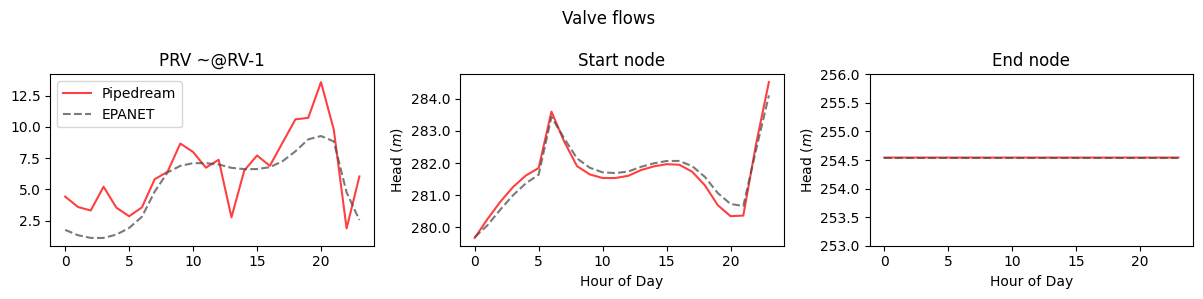

In [22]:
# plot pipedream and wntr PRV flows and upstream + downstream node heads
n_superlinks = wn.num_valves
n_cols = 3
n_rows =wn.num_valves  

if wn.num_valves > 0:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 0.75 * 12 * n_rows / n_cols))
    for i in range(wn.num_valves):
        valve = wn.get_link(wn.valve_name_list[i])
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*Q_prv[:,i:i+1], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*wntr_results_flow[wn.valve_name_list[i]], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i].set_title(f'{wn.get_link(wn.valve_name_list[i]).valve_type} {wn.valve_name_list[i]}')

        ax.flat[3*i+1].plot(H_df.index/3600,H_df[valve.start_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+1].plot(wntr_results_head.index/3600,wntr_results_head[valve.start_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+1].set_title('Start node')
        ax.flat[3*i+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+1].set_ylabel('Head ($m$)')
        ax.flat[3*i+1].set_xlabel('Hour of Day')

        ax.flat[3*i+2].plot(H_df.index/3600,H_df[valve.end_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+2].plot(wntr_results_head.index/3600,wntr_results_head[valve.end_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+2].set_title('End node')
        ax.flat[3*i+2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.flat[3*i+2].set_ylabel('Head ($m$)')
        ax.flat[3*i+2].set_xlabel('Hour of Day')
        ax.flat[3*i+2].set_ylim(math.floor(wntr_results_head[valve.end_node_name][0])-1, math.ceil(wntr_results_head[valve.end_node_name][0])+1)


    ax.flat[0].legend()
    plt.suptitle('Valve flows')
    plt.tight_layout()

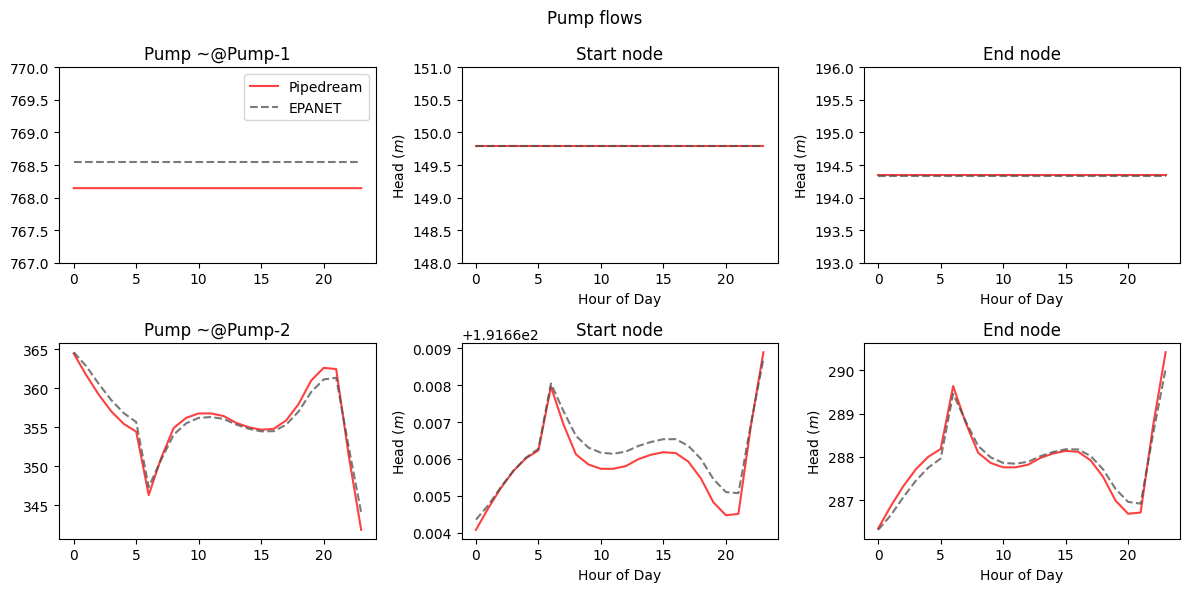

In [23]:
# plot pipedream and wntr pump flows and upstream + downstream node heads
n_superlinks = wn.num_pumps
n_cols = 3
n_rows = wn.num_pumps

if wn.num_pumps > 0:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 0.75 * 12 * n_rows / n_cols))
    for i in range(wn.num_pumps):
        pump = wn.get_link(wn.pump_name_list[i])
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*Q_pump[:,i:i+1], c='r', alpha=0.75)
        ax.flat[3*i].plot(wntr_results_flow.index/3600,3600*wntr_results_flow[wn.pump_name_list[i]], c='0.3', linestyle = '--', alpha=0.75)
        ax.flat[3*i].set_title(f'Pump {wn.pump_name_list[i]}')
          
            
        ax.flat[3*i+1].plot(H_df.index/3600,H_df[pump.start_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+1].plot(wntr_results_head.index/3600,wntr_results_head[pump.start_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+1].set_title('Start node')
        ax.flat[3*i+1].set_ylabel('Head ($m$)')
        ax.flat[3*i+1].set_xlabel('Hour of Day')

        ax.flat[3*i+2].plot(H_df.index/3600,H_df[pump.end_node_name], c='r', alpha=0.75, label = 'Pipedream')
        ax.flat[3*i+2].plot(wntr_results_head.index/3600,wntr_results_head[pump.end_node_name], c='0.3', linestyle = '--', alpha=0.75, label = 'EPANET')
        ax.flat[3*i+2].set_title('End node')
        ax.flat[3*i+2].set_ylabel('Head ($m$)')
        ax.flat[3*i+2].set_xlabel('Hour of Day')

        if i==0:
            ax.flat[3*i].set_ylim(math.floor(3600*wntr_results_flow[wn.pump_name_list[i]][0])-1,math.ceil(3600*wntr_results_flow[wn.pump_name_list[i]][0])+1)
            ax.flat[3*i+1].set_ylim(math.floor(wntr_results_head[pump.start_node_name][0])-1,math.ceil(wntr_results_head[pump.start_node_name][0])+1)
            ax.flat[3*i+2].set_ylim(math.floor(wntr_results_head[pump.end_node_name][0])-1,math.ceil(wntr_results_head[pump.end_node_name][0])+1)
    
    ax.flat[0].legend(['Pipedream','EPANET', 'EPANET original'])
    plt.suptitle('Pump flows')
    plt.tight_layout()